# Verify behavior cloning

Visually verify a behavior cloning based robot controller.

* Load the controller trained by the Train_BC notebook and the corresponding sp
* Choose a demonstration, to which the SP/BC pair will be applied to the images
* Visualize the path taken by the demonstration and what would be (autoregressively) recommended by the controller

In [1]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch
# import torch.nn as nn
# import torch.optim as optim
import numpy as np

from bc_factory import create_bc_model
# FIXME: factor this out
from bc_LSTM_MDN import bc_LSTM_MDN, mdn_loss

torch.manual_seed(1)
from sensorprocessing.sp_helper import get_transform_to_sp
from sensorprocessing.sp_factory import create_sp
from demonstration.demonstration import Demonstration

from robot.al5d_position_controller import RobotPosition
import bc_factory 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\pathlib\__init__.py
***ExpRun**: Loading pointer config file:
	C:\Users\lotzi\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	c:\Users\lotzi\Work\_Config\BerryPicker\cfg\settings.yaml
Using device: cuda


In [2]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"

# If not None, set an external experiment path
external_path = None

# If not None, set an output path
data_path = None

experiment = "behavior_cloning"
run = None
# run = "bc_verify_mlp_00"
# run = "bc_verify_lstm_00"
# run = "bc_verify_lstm_resid_00"
# run = "bc_verify_lstm_mdn_00"


# **** The settings below are used to debug a particular run in flow 
# **** They do not affect the run of the flow, 
# **** because they are going to be overwritten by papermill when run in a flow
creation_style = "exist-ok"
data_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/result"
external_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/exprun"
experiment = "behavior_cloning"
# run = "_flow_bc_mlp_0001_verify"
run = "_flow_bc_lstm_0001_verify"



In [3]:
if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
    Config().copy_experiment("behavior_cloning")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)
    
# temporary solution
# Setting up a separate directory for generated and computed data

exp = Config().get_experiment(experiment, run, creation_style=creation_style)
pprint.pprint(exp)

# Create the sp object described in the experiment
exp_sp = Config().get_experiment(exp["exp_sp"], exp["run_sp"])
sp = create_sp(exp_sp, device)
transform = get_transform_to_sp(exp_sp)

exp_robot = Config().get_experiment(exp["exp_robot"], exp["run_robot"])

# Load the bc model described in the experiment
exp_bc = Config().get_experiment(exp["exp_bc"], exp["run_bc"])
model, _, _ = create_bc_model(exp_bc, exp_sp, device)
model_path = pathlib.Path(exp_bc.data_dir(), exp_bc["controller_file"])
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))   
# model.load_state_dict(torch.load(model_path))

***ExpRun**: Experiment config path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun
***ExpRun**: Experiment sensorprocessing_conv_vae copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\sensorprocessing_conv_vae
***ExpRun**: Experiment robot_al5d copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\robot_al5d
***ExpRun**: Experiment demonstration copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\demonstration
***ExpRun**: Experiment behavior_cloning copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\behavior_cloning
***ExpRun**: Experiment data path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result
***ExpRun**: Configuration for exp/run: behavior_cloning/_flow_bc_lstm_0001_verify successfully loaded
Experiment:
    batch_size: 64
    control_size: 6
    data_dir: c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\behavi

<All keys matched successfully>

In [4]:
def teacher_forcing(sp, model, sequence_length, data_spec, pred_path, teacher_path):
    """Cached version of teacher forcing, returns the precomputed values if they exist."""
    if pred_path.exists() and teacher_path.exists():
        a_pred_np = np.load(pred_path)
        a_teacher_np = np.load(real_path)
        print(f"Paths successfully loaded from\n{pred_path.relative_to(pathlib.Path.home())}")
        return a_pred_np, a_teacher_np
    else:
        return run_teacher_forcing(sp = sp, model = model, sequence_length = sequence_length, data_spec = data_spec, pred_path = pred_path, teacher_path = teacher_path )


In [5]:

@torch.no_grad
def run_teacher_forcing(sp, model, sequence_length, data_spec, pred_path, teacher_path):
    """Runs behavior cloning on a demonstration in teacher forcing mode. For each step, it creates 
    FIXME: model should be a more wrapped thing, not just the torch model
    """
    a_teacher_list = []
    a_pred_list = []
    for val in data_spec: # for all demonstrations
        run, demo_name, camera = val
        exp_demo = Config().get_experiment("demonstration", run)
        demo = Demonstration(exp_demo, demo_name)
        # perform the run for each of the demonstrations
        for i in range(demo.metadata["maxsteps"]-sequence_length): # -1 because of lookahead
            #
            # This is the part where we create the input to the controller
            # 
            if sequence_length:
                # if the sequence length is not zero, we read ahead that much, and create the list
                input_list = []
                # FIXME make it sliding window
                for j in range(sequence_length):
                    sensor_readings, _ = demo.get_image(i+j, device=device, transform=transform, camera=camera)
                    #if sensor_readings is not None:
                    #    print(f"reading {i+j} successful")
                    #else:
                    #    print(f"reading {i+j} not successful, returned none")
                    z = sp.process(sensor_readings)
                    input_list.append(z)
                    input_nd = np.array(input_list)
                    z_tensor = torch.tensor(input_nd).unsqueeze(0).to(device)
            else:
                # sequence length it zero, it is just the current image
                sensor_readings, _ = demo.get_image(i, device=device, transform=transform, camera=camera)
                z = sp.process(sensor_readings)
                z_tensor = torch.tensor(z).unsqueeze(0).to(device)
            #
            # Calling the controller
            # 
            if not isinstance(model, bc_LSTM_MDN):                
                a_pred = model(z_tensor)
            else:
                a_pred = model.forward_and_sample(z_tensor)
            a_pred_list.append(a_pred.to("cpu").squeeze(0))
            rp = demo.get_action(i, "rc-position-target", exp_robot)
            # a = demo.get_action(i)
            # rp = RobotPosition.from_vector(exp_robot, a)
            a_teacher = rp.to_normalized_vector(exp_robot)            
            a_teacher_list.append(a_teacher)
    a_pred_np = np.array(a_pred_list)
    a_teacher_np = np.array(a_teacher_list)

    # save the comparison terms
    np.save(pred_path, a_pred_np)
    np.save(teacher_path, a_teacher_np)   
    return a_pred_np, a_teacher_np            

In [6]:
sequence_length = exp_bc["sequence_length"]

# run for the verification data 
pred_path = pathlib.Path(exp.data_dir(), "teaforce_predicted_verifdata")
teacher_path = pathlib.Path(exp.data_dir(), "teaforce_teacher_verifdata")
a_pred_verif_np, a_teacher_verif_np = teacher_forcing(sp, model, sequence_length, exp["verification_data"], pred_path = pred_path, teacher_path = teacher_path)

# run for the training data 
pred_path = pathlib.Path(exp.data_dir(), "teaforce_predicted_traindata")
teacher_path = pathlib.Path(exp.data_dir(), "teaforce_teacher_traindata")
a_pred_train_np, a_teacher_train_np = run_teacher_forcing(sp, model, sequence_length, exp["training_data"], pred_path = pred_path, teacher_path = teacher_path)

***ExpRun**: Configuration for exp/run: demonstration/touch-apple successfully loaded
***ExpRun**: Configuration for exp/run: demonstration/touch-apple successfully loaded
***ExpRun**: Configuration for exp/run: demonstration/random-both-cameras-video successfully loaded
***Demonstration***: parsing image based demonstration


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\lotzi\\Work\\_Data\\BerryPicker-Flows\\BC-touch-apple\\result\\demonstration\\random-both-cameras-video\\2025_03_08__14_15_53'

## Plot the differences between the a_real and a_pred

In [ ]:

def generate_teacher_forcing_plots(a_pred_np, a_real_np, fileroot):
    fig, axs = plt.subplots(2,3, figsize=(8, 6))
    for i in range(exp_bc["control_size"]):
        ax = axs[i//3, i%3]
        ax.set_ylim(-0.1, 1.1)
        ax.plot(a_real_np[:,i], label="ground truth")
        if len(a_pred_np.shape) == 3:
            ax.plot(a_pred_np[:,0,i], label=exp_bc["name"])
        else:
            ax.plot(a_pred_np[:,i], label=exp_bc["name"])
        if i==0:
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, ncol=2,
                bbox_to_anchor=(0.5, 0), loc="upper center")
        ax.set_title(RobotPosition.FIELDS[i])

    plt.tight_layout()
    fig_verify_pdf_path = pathlib.Path(exp.data_dir(), f"{fileroot}.pdf")
    plt.savefig(fig_verify_pdf_path, bbox_inches='tight')
    fig_verify_jpg_path = pathlib.Path(exp.data_dir(), f"{fileroot}.jpg")
    plt.savefig(fig_verify_jpg_path, bbox_inches='tight')

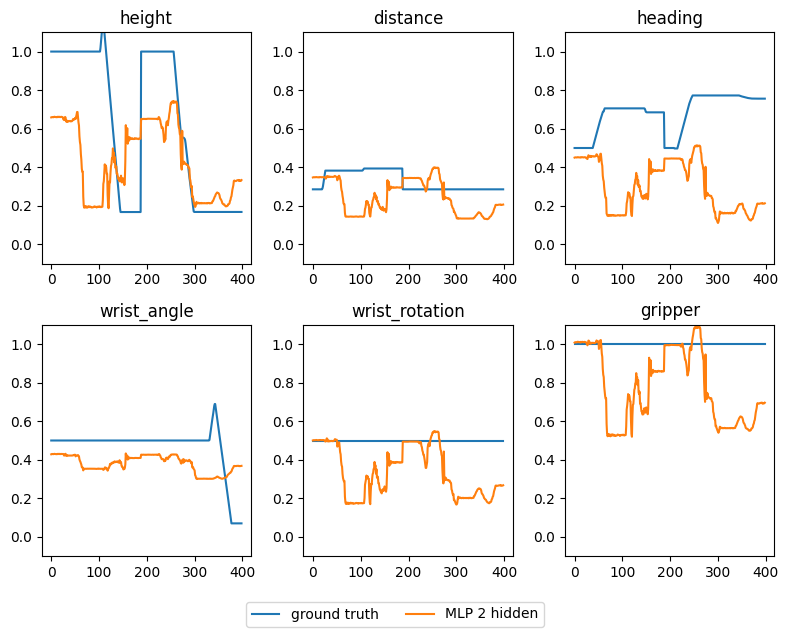

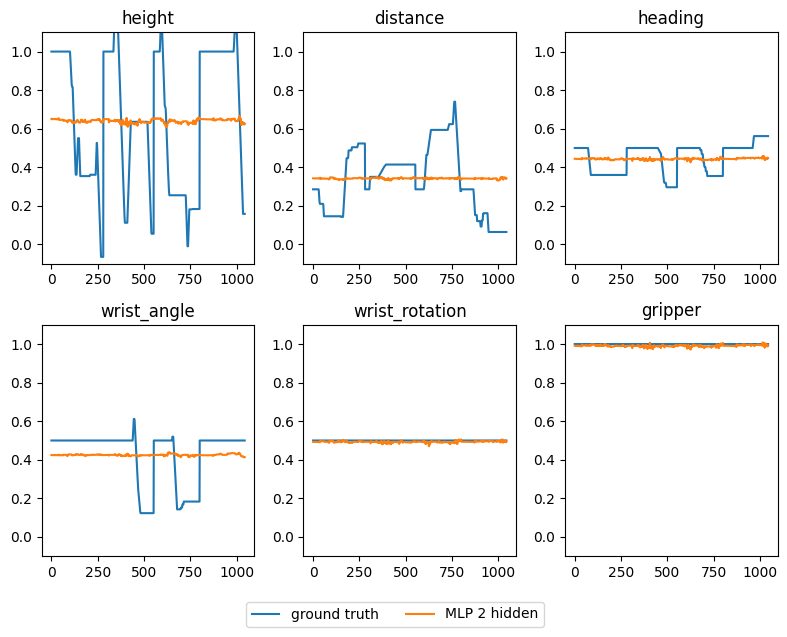

In [ ]:
generate_teacher_forcing_plots(a_pred_verif_np, a_teacher_verif_np, "teacher_forcing_verify")
generate_teacher_forcing_plots(a_pred_train_np, a_teacher_train_np, "teacher_forcing_training")


In [ ]:
# print(exp_bc)

a_real_np.shape
# a_real_np[:,1]

NameError: name 'a_real_np' is not defined

In [ ]:
len(a_pred_np.shape)

In [ ]:
exp_bc